# Racial disparities in weekend killings

One of hallmark projects produced by the Data Desk is [The Homicide Report](http://homicide.latimes.com/), which gives a space to tell the story of every person killed in Los Angeles County.

The foundation for the database is a regular feed of all deaths deemed as homicides by the county coroner. Over 15 years, the data set has become volumninous (though it is growing slower now than before), which makes it great for analyses.

My [frequent](http://graphics.latimes.com/building-and-safety-complaints/) [partner](http://spreadsheets.latimes.com/l-countys-dangerous-intersections/) in data crime, Armand Emamdjomeh, oversees the production and development of the database. While doing some queries, he noticed something interesting: It seemed that Latinos were getting killed more frequently over weekends than other races.

The plots of this trend were fairly compelling. But we weren't sure if this finding was something other than a product of chance. Any comparison would have to account for the fact that the subsets of data were disparate in size: Latinos are the most frequently killed race in the county, by a fairly wide margin, followed by blacks and then whites.

After some discussion, we decided to calculate risk and odds ratios of whether a death occurred on the weekend or not for each racial group. Finally, we pooled all of the odds together into a logisitic regression model in R, to see if [weekends really were the deadliest time for Latinos](http://homicide.latimes.com/post/weekend-homicides/).

### Plotting the trends

We started with the pre-processed data set of every death the coroner has deemed a homicide since 2000 (more than 14,000) and subset to get what we need for this analysis.

In [1]:
HOMICIDES <- read.csv('misc-files/all_homicides.csv',
                      stringsAsFactors = FALSE)

In [2]:
print(names(HOMICIDES))

 [1] "ID"                      "coroners.case.number"   
 [3] "police.case.number"      "da.case.number"         
 [5] "first.name"              "middle.name"            
 [7] "last.name"               "suffix"                 
 [9] "slug"                    "age"                    
[11] "cause"                   "security.hold"          
[13] "gender"                  "race"                   
[15] "day.of.week"             "neighborhoodv5_id"      
[17] "neighborhoodv6_id"       "jurisdiction_id"        
[19] "coroners.description"    "death.date"             
[21] "death.time"              "died.on.scene"          
[23] "incident.address"        "incident.zipcode"       
[25] "blog.item.url"           "image"                  
[27] "officer.involved"        "law.enforcement.officer"
[29] "domestic.violence"       "ruling"                 
[31] "incident.point.4326"     "incident.point.900913"  
[33] "incident.point.3857"     "full.name"              
[35] "formatted.death.date"    

In [3]:
day_info <- HOMICIDES[,c(1,10,11,14,15)]
names(day_info) <- c('id','age','cause','race','day')

In [4]:
str(day_info)

'data.frame':	14302 obs. of  5 variables:
 $ id   : int  14694 14691 14690 14693 14668 14698 14696 14695 14661 14692 ...
 $ age  : int  33 32 28 22 20 16 39 30 37 42 ...
 $ cause: chr  "gunshot" "stabbing" "gunshot" "gunshot" ...
 $ race : chr  "latino" "white" "latino" "latino" ...
 $ day  : chr  "tuesday" "tuesday" "monday" "monday" ...


In [5]:
head(day_info)

,id,age,cause,race,day
1,14694,33,gunshot,latino,tuesday
2,14691,32,stabbing,white,tuesday
3,14690,28,gunshot,latino,monday
4,14693,22,gunshot,latino,monday
5,14668,20,gunshot,black,sunday
6,14698,16,gunshot,black,sunday


A personal sidebar: I personally hate factors in R, owing to the fact that strings by default will be treated as R's built-in data type for categorial variables ([for some good reasons I'm not willing to appreciate](http://simplystatistics.org/?p=4151)) unless you say otherwise. But factors can be useful if you need your categorical variables in a particular order, as I do right now for days of the week.

In [6]:
day_info$day <- factor(day_info$day,
                       levels = c("monday","tuesday","wednesday","thursday","friday","saturday","sunday"),
                       ordered = TRUE)

A quick table shows us that a little less than half of all homicides occur on the weekend days of Friday, Saturday and Sunday.

In [7]:
prop.table(table(day_info$day))


   monday   tuesday wednesday  thursday    friday  saturday    sunday 
0.1374633 0.1259964 0.1191442 0.1209621 0.1342470 0.1724934 0.1896937 

Another quick table shows what I mentioned above: Latinos account for almost half of all homicides in the county.

In [8]:
table(day_info$race) / nrow(day_info)


                    asian        black       latino        other        white 
0.0112571668 0.0374772759 0.3391833310 0.4928681303 0.0005593623 0.1186547336 

We can cross-tabulate deaths by days of the week and race, then plot it out for the biggest racial groups in these data to see the disparities by group.

In [9]:
byraceday <- data.frame(prop.table(table(day_info$race, day_info$day), 1))
names(byraceday) <- c("race","day","percent")
byraceday <- byraceday[byraceday$race %in% c('black','latino','white'),]

In [10]:
library(ggplot2)

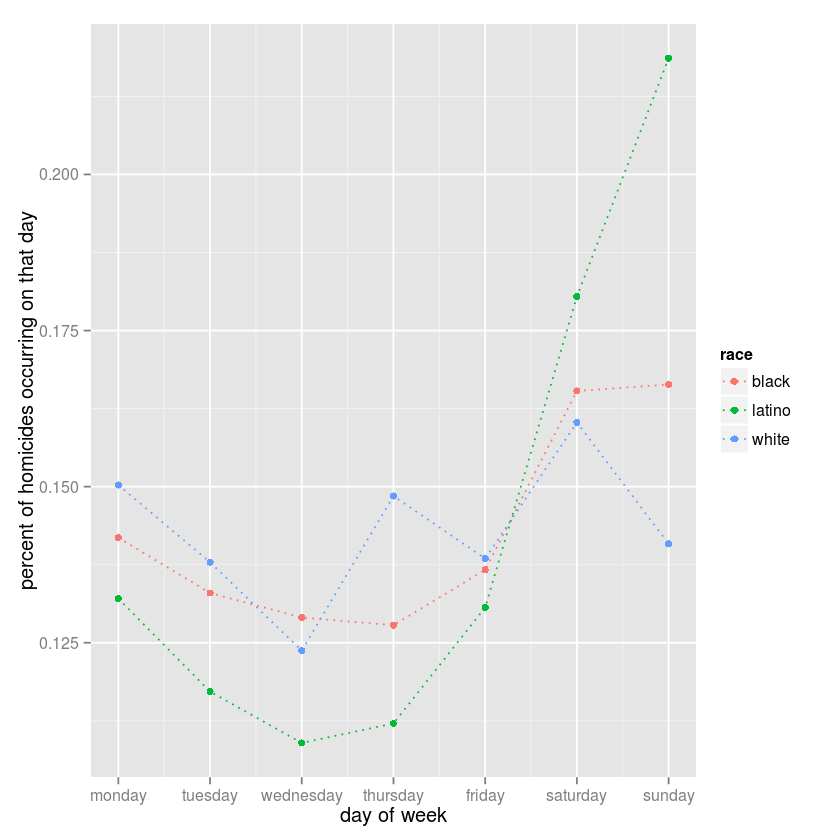

In [11]:
ggplot(byraceday, aes(x = as.numeric(day), y = percent, group = race, color = race)) + 
geom_line(linetype="dotted") +
geom_point() +
scale_x_continuous(breaks = 1:7,
                   labels=c('monday','tuesday','wednesday','thursday','friday','saturday','sunday')) +
labs(x = "day of week", y = "percent of homicides occurring on that day")

It is said that you should use line plots only for time series. This is not a time series, but since there is a temporal aspect to it we made the conscientious decision to connect the dots with dashed lines in Armand's [D3 visualization of the above](http://homicide.latimes.com/post/weekend-homicides/).

This trend is pretty striking. Latinos are clearly dying more frequently on the three weekend days than the four weekdays, outpacing other racial groups. It is also interesting that this skew toward the weekend holds for Latino victims, but doesn't for either white or black victims.

From here, we started comparing risk ratios pairwise across different racial groups (using a significance test in an R package called "epiR") and found the Latino weekend rate was always significantly higher.

### Logisitic regression

The many folds of our analysis can best be put together in a logistic regression model, where we test for statistical significance if the race of victim can predict a binary outcome: whether the victim died on a weekend day or not.

To do this, we first need to quickly codify our dependent variable as true or false.

In [12]:
day_info$weekend <- day_info$day %in% c("friday","saturday","sunday")

In [13]:
head(day_info)

,id,age,cause,race,day,weekend
1,14694,33,gunshot,latino,tuesday,FALSE
2,14691,32,stabbing,white,tuesday,FALSE
3,14690,28,gunshot,latino,monday,FALSE
4,14693,22,gunshot,latino,monday,FALSE
5,14668,20,gunshot,black,sunday,TRUE
6,14698,16,gunshot,black,sunday,TRUE


Another table shows us how Latinos carry this weekend trend, but other racial groups do not.

In [14]:
prop.table(table(day_info$race, day_info$weekend), 1)

        
             FALSE      TRUE
         0.5590062 0.4409938
  asian  0.4925373 0.5074627
  black  0.5316430 0.4683570
  latino 0.4702795 0.5297205
  other  0.3750000 0.6250000
  white  0.5604007 0.4395993

With that, we can push the data into R's built in `glm` function and set up the parameters to do a logistic regression.

In [15]:
model <- glm(weekend ~ race, data = day_info, family = "binomial")

In [16]:
summary(model)


Call:
glm(formula = weekend ~ race, family = "binomial", data = day_info)

Deviance Residuals: 
   Min      1Q  Median      3Q     Max  
-1.401  -1.190  -1.076   1.127   1.282  

Coefficients:
             Estimate Std. Error z value Pr(>|z|)  
(Intercept) -0.237130   0.158730  -1.494   0.1352  
raceasian    0.266983   0.180719   1.477   0.1396  
raceblack    0.110389   0.161316   0.684   0.4938  
racelatino   0.356152   0.160514   2.219   0.0265 *
raceother    0.747955   0.747229   1.001   0.3168  
racewhite   -0.005659   0.166094  -0.034   0.9728  
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

(Dispersion parameter for binomial family taken to be 1)

    Null deviance: 19826  on 14301  degrees of freedom
Residual deviance: 19755  on 14296  degrees of freedom
AIC: 19767

Number of Fisher Scoring iterations: 3


Our model is showing that the Latino group is the only one occuring outside the bounds of random chance, at the 95% significance level. 

To see why, let's convert the estimates, which are outputted as log odds, into regular odds, and draw around those their respective confidence intervals.

In [17]:
exp(cbind(OR = coef(model), confint(model)))

Waiting for profiling to be done...


,OR,2.5 %,97.5 %
(Intercept),0.7888889,0.5764987,1.0754079
raceasian,1.3060179,0.9174339,1.8647479
raceblack,1.1167119,0.8150193,1.5357526
racelatino,1.427825,1.043734,1.960578
raceother,2.1126756,0.5014063,10.5798495
racewhite,0.9943573,0.7189063,1.3801178


These odds ratios, while somewhat difficult to explain to a general audience, are exactly what we want to compare. 

For each racial group, it is telling us the odds that a Latino person was killed on the weekend (number of weekend deaths divided by number of weekday deaths) divided by the odds that someone in the control group was killed on the weekend.

In R, when a categorial variable is inputted into a regression model each category is measured against the first category in alphabetical order. In this case, each racial group was measured against the group that had a null race column in the data (about 160 for which the coroner could not make a determination). Since each race is being compared to the same control group, comparing their odds ratios is a valid exercise.

For example: We can use the raw totals to make some calculations by hand for the Latino group.

In [18]:
table(day_info$race, day_info$weekend)

        
         FALSE TRUE
            90   71
  asian    264  272
  black   2579 2272
  latino  3315 3734
  other      3    5
  white    951  746

If you divide the number of weekend deaths of Latinos (3734) by the number of weekday deaths (3315) you get the odds of a Latino dying on the weekend, about 1.13. The odds for the control group is 71 divided by 90, or 0.79. The ratio of those two odds is 1.43, which is the coefficient for Latinos in the table above.

The odds ratios are easy enough to calculate, but the real value of doing a logisitic regression is analyzing the confidence intervals around the ratio, which take into account the size of each sample. If the confidence interval of an odds ratio includes 1, we cannot say that that odds for that racial group is statistically significantly higher than the control group.

Since Latinos are the only group for which the confidence interval does not include 1, we can conclude that weekends are a deadlier time for Latinos than other racial groups.

### What we wrote

As mentioned above, odds are a bit of a nebulous concept for readers, perhaps due to the fact that their statistical definition is often obscured by the definition of the term in gambling circles.

With our conclusion in hand, we decided to turn to the "risk ratio" to best explain this in our write-up. The risk ratio allows us to say how much more likely it is a Latino killing occurs on the weekend than a killing of any other race.

Let's calculate the risk for Latinos first:

In [19]:
day_info$islatino <- day_info$race == 'latino'

In [20]:
latino_wknd <- sum(day_info$islatino & day_info$weekend); print(latino_wknd)
latino <- sum(day_info$islatino); print(latino)
latino_wknd_risk <- latino_wknd / latino; print(latino_wknd_risk)

[1] 3734
[1] 7049
[1] 0.5297205


And the same for all other groups:

In [21]:
others_wknd <- sum(!day_info$islatino & day_info$weekend); print(others_wknd)
others <- sum(!day_info$islatino); print(others)
others_wknd_risk <- others_wknd / others; print(others_wknd_risk)

[1] 3366
[1] 7253
[1] 0.4640838


The risk ratio, then, is:

In [22]:
latino_wknd_risk / others_wknd_risk

[1] 1.141433

At the time we did the analysis, the ratio was closer to 1.15, so this is what we included as our nut-graf from the data:

> The average Latino homicide victim in Los Angeles County is 15% more likely to be killed on a weekend — defined here as Friday, Saturday or Sunday — than victims of other races or ethnicities, according to a Times analysis of the more than 13,000 Los Angeles County homicides recorded from 2000 to 2014 in the Homicide Report.

After some interviews, Armand and I formed a brief qualitative discussion around the statistical conclusions, and the story ran Feb. 27, 2015 as the regular Homicide Report column in the California section of the newspaper. 